In [340]:
import numpy as np # importa Numpy
import matplotlib.pyplot as plt # importa Matplotlib
import scipy.ndimage as ndi # importa Scipy per le immagini
import skimage.io as io # importa il modulo Input/Output di SK-Image
import mylib

# La trasformata di Fourier discreta 2D (DFT-2D)
La trasformata di Fourier considerata sarà quella DFT in particolare perché possiamo memorizzare solo un numero finito di campioni su un supporto di memoria. Si usa la funzione **fft2** presente in numpy che calcola la DFT di una matrice specificata (l'immagine). 
Per fare la DFT bisogna indicare il numero di campioni ma in automatico vengono presi NxM campioni (la lunghezza del vettore specificato). Questo va bene per le immagini perché sono descritte da centinaia di campioni ma nel caso di maschere non va assolutamente bene perché una maschera 3x3 avrà 9 campioni che sono pochi per fare la DFT.

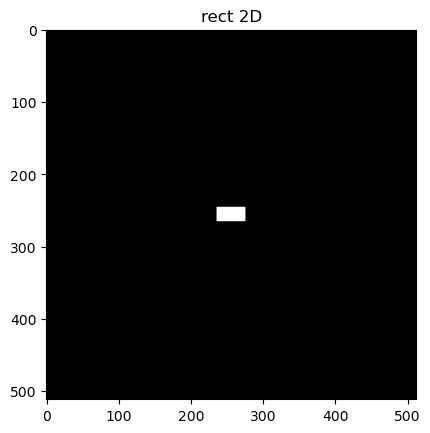

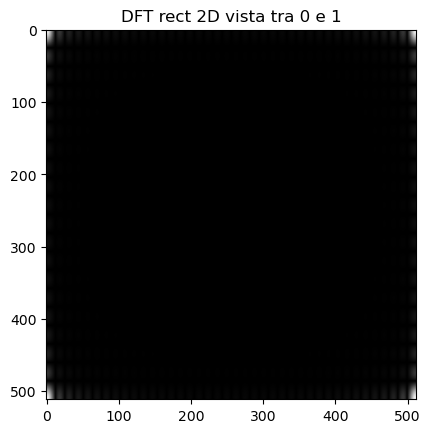

In [341]:
x = np.float64(io.imread('immagini\\rettangolo.jpg'))
X = np.fft.fft2(x)
plt.figure(); plt.title('rect 2D'); plt.imshow(x, clim=None, cmap='gray')
plt.figure(); plt.title('DFT rect 2D vista tra 0 e 1'); plt.imshow(np.abs(X), clim=None, cmap='gray');

L'output è la trasformata di una rect quindi dovrebbe essere una sinc. Anzitutto le basse frequenze stanno ai bordi, si vede tutto nero. Vorrei shiftare al centro le basse frequenze come visto in teoria. Poi applico il logaritmo così che "espando" i valori scuri e comprimo quelli chiari.

Si usa la funzione **fftshift(x)** che permette di posizionare le basse frequenze al centro e le alte ai bordi. 

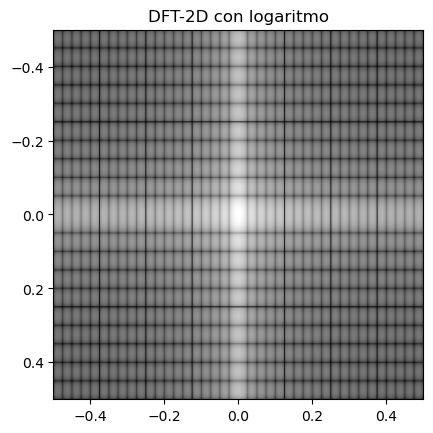

In [342]:
Y = np.log(1+np.abs(np.fft.fftshift(X)))
plt.figure(); plt.title('DFT-2D con logaritmo')
plt.imshow(Y, clim=None, cmap='gray', extent=(-0.5,+0.5,+0.5,-0.5)); 
#extent cambia valori sugli assi perche voglio vedere lo spettro tra -1/2 e 1/2

E' una sinc bidimensionale però vista in 2D, per visualizzarla in 3D uso i comandi:

C:\Users\duckw\AppData\Local\Temp\ipykernel_16132\2809568146.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(plt.figure()); # crea una figura per i grafici 3d


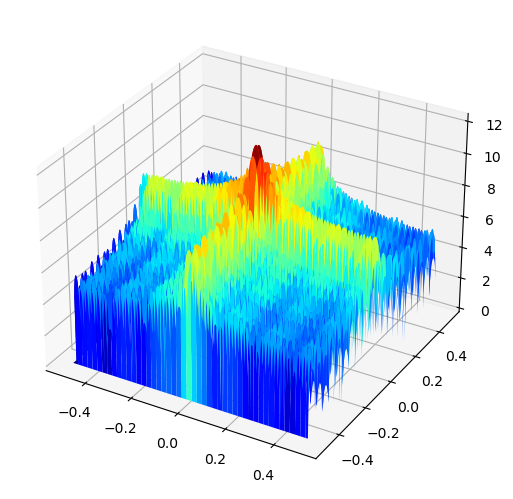

In [343]:
Y = np.log(1+np.abs((np.fft.fftshift(X))))
m = np.fft.fftshift(np.fft.fftfreq(Y.shape[0]))
n = np.fft.fftshift(np.fft.fftfreq(Y.shape[1]))

from mpl_toolkits.mplot3d import Axes3D
ax = Axes3D(plt.figure()); # crea una figura per i grafici 3d
l,k = np.meshgrid(n,m)
ax.plot_surface(l,k,Y, linewidth=0, cmap='jet')

## Visualizzazione del filtro media aritmetica in frequenza
La DFT per essere corretta deve essere calcolata su almeno NxM punti che sono esattamente i punti che prende fft2 però possiamo anche cambiare dandogli in input una tupla che lo indica (vedere codice sotto). Il motivo è che su un immagine 512x512 non c'è nessun problema se prendi 512x512 campioni, ma se applico la trasformata su una maschera 3x3 vado a prendere soltanto 9 campioni per calcolare la DFT, e sono pochissimi.

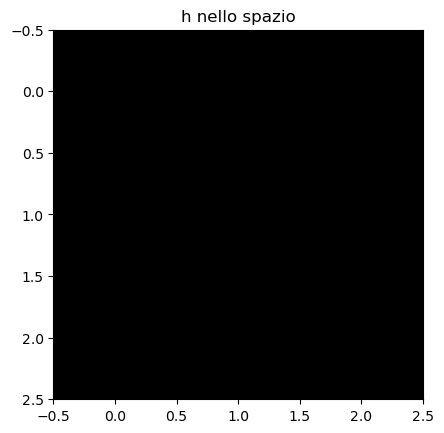

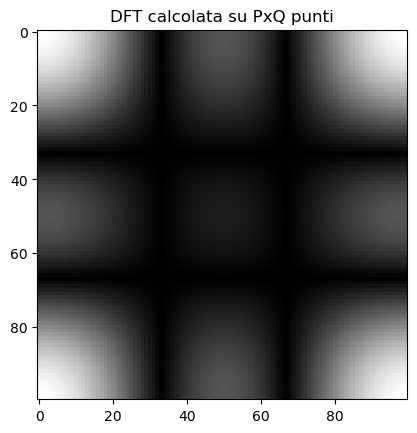

In [344]:
k = 3 #dimensione della maschera
h = np.ones((k,k))/(k**2) #creo una maschera di media aritmetica

P = 100; Q = 100
X = np.fft.fft2(h, (P,Q)) #faccio la dft su PxQ punti anziché 3x3 punti come di default
plt.figure(); plt.title('h nello spazio'); plt.imshow(h, clim=None, cmap='gray')
plt.figure(); plt.title('DFT calcolata su PxQ punti'); plt.imshow(np.abs(X), clim=None, cmap='gray');


Dal grafico 3D si vede che è un passa-basso.

### Esercizi proposti
2. **Spettro di fase**: per comprendere l’importanza dello spettro di fase provate a realizzare il seguente esperimento. Considerate l’immagine volto.tif e dopo averne calcolato e visualizzato spettro di ampiezza e di fase, ricostruite l’immagine con la sola informazione di ampiezza e poi solo con quella di fase e confrontate le due immagini.
Infine, provate a ricostruire l’ immagine usando una volta il suo spettro di ampiezza, ma quello di fase
relativo all’immagine rettangolo.jpg e una seconda volta il suo spettro di fase, ma quello di ampiezza
sempre relativo all’immagine rettangolo.jpg.

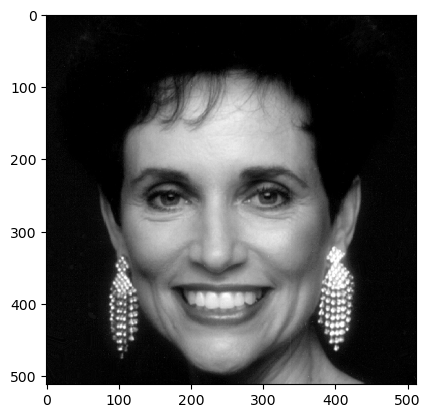

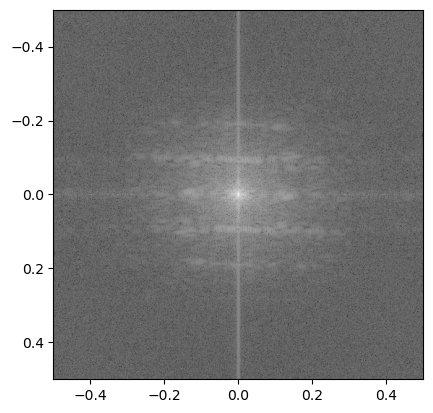

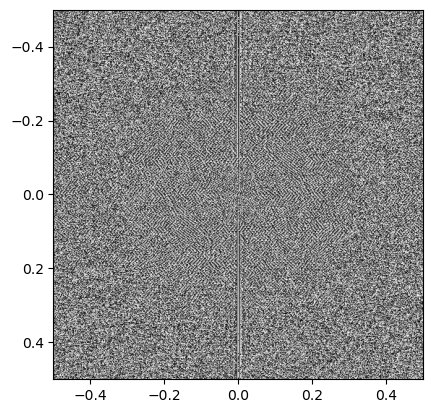

In [345]:
x = np.float64(io.imread('immagini\\volto.tif'))
X = np.fft.fftshift(np.fft.fft2(x))
plt.figure(); plt.imshow(x, clim=None, cmap='gray')
plt.figure(); plt.imshow(np.log(1+np.abs(X)), clim=None, cmap='gray',extent=(-0.5,+0.5,+0.5,-0.5));
#applico direttamente il log perché già so che è lo spettro d'ampiezza è tutto scuro
plt.figure(); plt.imshow(np.angle(X), clim=[-np.pi, np.pi], cmap='gray', extent=(-0.5,+0.5,+0.5,-0.5));


In [346]:
X1 = np.abs(X) #prendo solo modulo
X2 = np.exp(1j*np.angle(X)) #prendo soltanto la fase

Per ricostruire il segnale devo fare l'antitrasformata di Fourier.

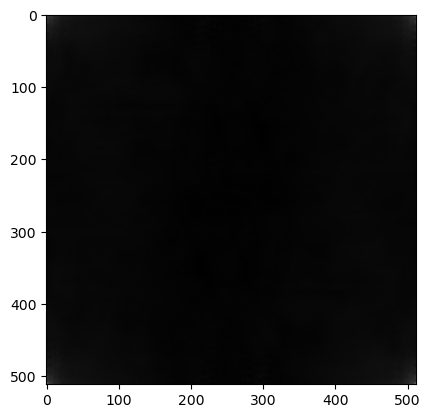

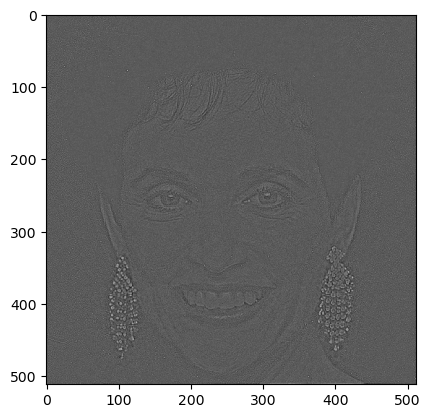

In [347]:
y1 = np.real(np.fft.ifft2(np.fft.ifftshift(X1)))
y2 = np.real(np.fft.ifft2(np.fft.ifftshift(X2)))

plt.figure(); plt.imshow(y1, clim=None, cmap='gray')
plt.figure(); plt.imshow(y2, clim=None, cmap='gray')



Usando soltanto la ricostruzione con la fase si vede già il volto. Mentre con l'ampiezza senza usare elaborazioni non si vede nulla.
La fase ci dice le sinusoidi che costruiscono il segnale di quanto devono essere shiftate. Toglierla vuol dire sommare sinusoidi casualmente.

# Uso della DFT per il filtraggio lineare
Tramite DFT posso controllare le frequenze di un'immagine grazie alla proprietà della trasformata di Fourier per cui abbiamo un **prodotto in frequenza se nel tempo/spazio ho una convoluzione**. Posso quindi decidere quali frequenze far passare, quali attenuare, aumentare, enfatizzare, etc... costruendo un filtro ad hoc. Se volessi realizzare un filtro LP allora posso creare una maschera in frequenza (binaria) con valori alti per le frequenze basse e nulli altrove. La forma del filtro dipende dal caso.


## Filtro di Sobel
Filtro usato per il riconoscimento dei contorni, fa uso dell'operatore **differenziale** quindi la somma dei coefficienti di h(m,n) = 0

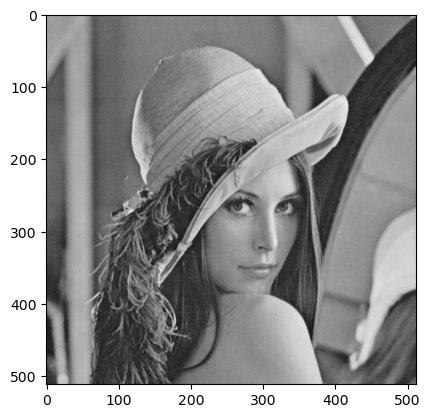

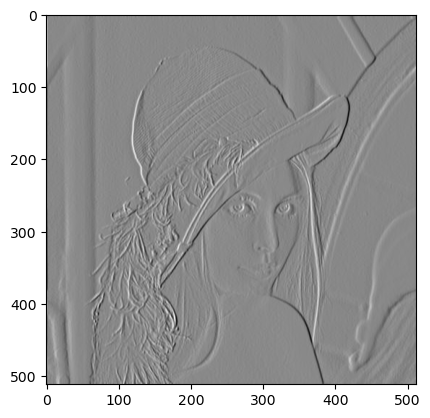

In [348]:
#definisco la matrice dell'immagine e la maschera nel dominio dello spazio
x = np.float64(io.imread('immagini\\lena.jpg'))
h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=np.float64) ##filtro nello spazio: SOBEL mi aspetto i dettagli

M,N = x.shape
A,B = h.shape

#buona norma: indicare P e Q anziché direttamente nella fft così posso cambiare più avanti
P = M
Q = N

#faccio la trasformata di Fourier di maschera e immagine
X = np.fft.fft2(x, (P,Q))
H = np.fft.fft2(h, (P,Q))


Y = H * X #convoluzione = prodotto in frequenza
y = np.real(np.fft.ifft2(Y)) #anti-trasformo dopo aver fatto il prodotto in frequenza
plt.figure(); plt.imshow(x, clim=[0,255], cmap='gray')
plt.figure(); plt.imshow(y, clim=None, cmap='gray');

Il risultato ottenuto sono proprio i contorni dell'immagine di Lena. Il filtro di Sobel è quindi stato applicato correttamente.

# Progetto dei filtri in frequenza
## Filtraggio con filtro ideale passa-basso
Voglio realizzare un filtro a forma di cilindro. Matematicamente vuol dire avere una risposta in frequenza che vale 1 se la distanza dal centro è minore del raggio del cilindro. La distanza dal centro del punto generico u e v si indica con:
$$
    D(\mu, \nu) = \sqrt{(\mu ^ 2 + \nu ^2 )}
$$
quindi posto D0 come raggio della frequenza cut-off, devo avere che 
$$
    D(\mu, \nu) \le D_0
$$

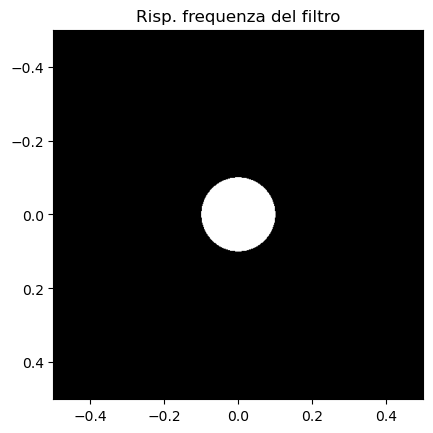

In [349]:
M,N = x.shape

#genero le frequenze normalizzate tra 0 e 1 con fftfreq, uso fftshift per spostare lo zero al centro
m = np.fft.fftshift(np.fft.fftfreq(M))
n = np.fft.fftshift(np.fft.fftfreq(N))

#creo la griglia 2D di frequenze l e k per calcolare la distanza dal centro
l,k = np.meshgrid(n,m)

#D è la distanza euclidea del generico punto dal centro a frequenza zero
D = np.sqrt(k**2+ l**2)

#raggio cut-off
D0 = 0.1;

#maschera del filtro passa basso ideale IN FREQUENZA
H = (D <= D0)

plt.figure(); plt.title('Risp. frequenza del filtro')
plt.imshow(H, clim=[0,1], cmap='gray', extent=(-0.5,+0.5,+0.5,-0.5));

Ora applico il filtro appena definito sull'immagine di Lena visualizzando il risultato del filtraggio.

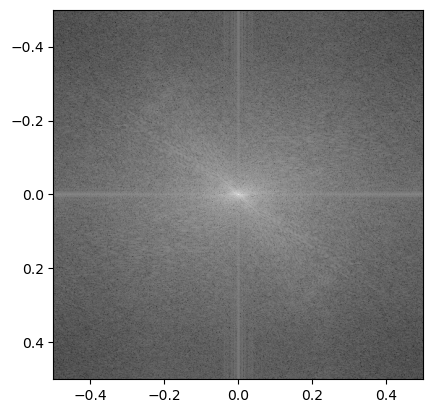

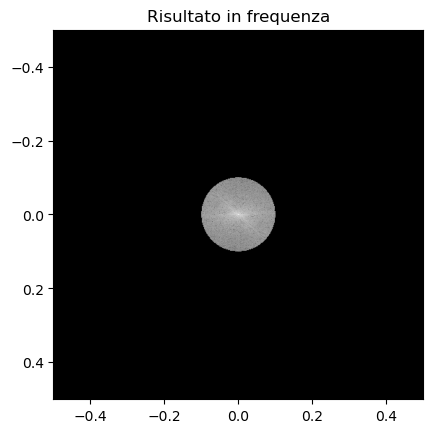

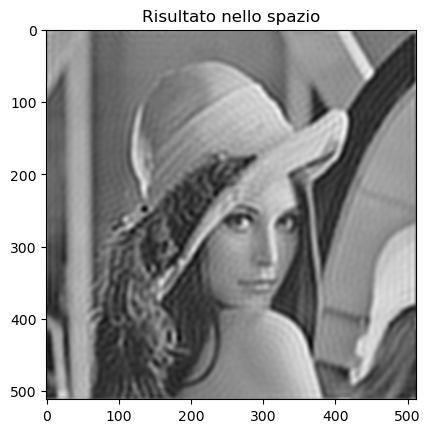

In [350]:
x = np.float64(io.imread('immagini\\lena.jpg'))
X = np.fft.fft2(x)
X = np.fft.fftshift(X)
plt.figure(); plt.imshow(np.log(1+np.abs(X)), clim=None, cmap='gray', extent=(-0.5,+0.5,+0.5,-0.5));

#filtraggio: calcolo il prodotto tra H e X
Y = H * X
plt.figure(); plt.title('Risultato in frequenza'); plt.imshow(np.log(1+np.abs(Y)), clim=None, cmap='gray', extent=(-0.5,+0.5,+0.5,-0.5));

Y = np.fft.ifftshift(Y)
y = np.real(np.fft.ifft2(Y))
plt.figure(); plt.title('Risultato nello spazio'); plt.imshow(y, clim=[0,255], cmap='gray');

### Osservazioni:
1. C'è l'effetto di ringing per via del filtro ideale, quindi nella realtà è meglio usare filtri reali come quello gaussiano che hanno un andamento dolce verso lo zero.
2. Il filtro ha totalmente distrutto le altre frequenze al di fuori del raggio cut-off.

## Filtraggio con filtro passa-basso Gaussiano 
Posso definire una funzione Python che in input prenda l'immagine e la deviazione standard e che applichi il filtro gaussiano su di essa.

In [351]:
def gaussLPF(x, sigma):
    """
    Un filtro Gaussiano permette di fare da filtro passa-basso reale che non causa ringing poiché ha un andamento
    più dolce verso lo zero rispetto ad un filtro circolare/rettangolare che presenta variazioni brusche
    """
    X = np.fft.fft2(x)
    X = np.fft.fftshift(X)

    M,N = x.shape

    m = np.fft.fftshift(np.fft.fftfreq(M))
    n = np.fft.fftshift(np.fft.fftfreq(N))

    l,k = np.meshgrid(n,m)

    #Definisco la distanza del generico punto k,l dal centro 
    D = np.sqrt(l**2 + k**2)

    #Definizione del filtro gaussiano in frequenza
    H = np.exp(-D**2 / (2*(sigma**2)))

    return np.real(np.fft.ifft2(np.fft.ifftshift(X*H)))


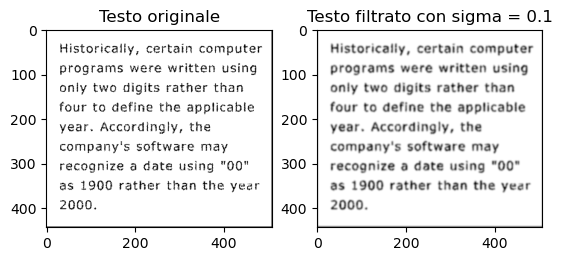

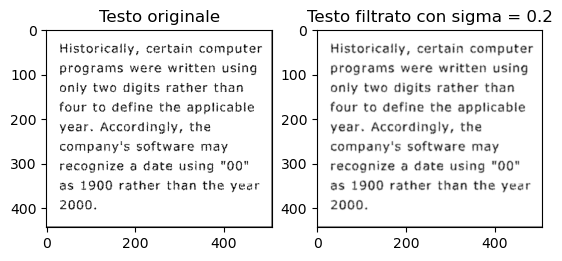

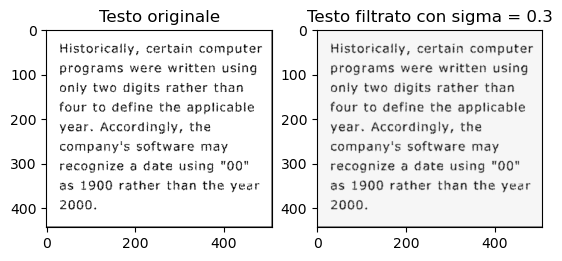

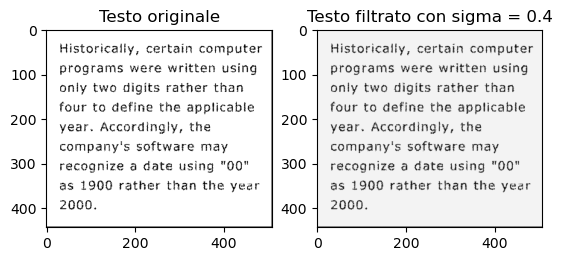

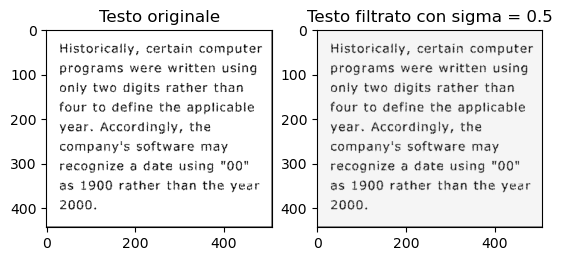

In [352]:
#Applico il filtro all'immagine testo.tif 

x = np.float64(io.imread('immagini\\testo.tif'))
#Definisco diversi valori di sigma per vedere la differenza nell'elaborazione usando dev. standard diverse
sigma = [0.1, 0.2, 0.3, 0.4, 0.5]

for dev in sigma:
    y = gaussLPF(x, dev)

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(x, clim=None, cmap='gray')
    plt.title('Testo originale')
    plt.subplot(1,2,2)
    plt.imshow(y, clim=None, cmap='gray')
    plt.title('Testo filtrato con sigma = ' + str(dev))


In questo caso il filtraggio potrebbe essere anteposto ad un riconoscitore di testo che farà meno errori elaborando il testo già filtrato.

## Filtraggio di rumore periodico

Alcune immagini sono disturbate da un rumore periodico che le rendono sgradevoli. Ad esempio l'immagine lenarumorosa.y è data dall'immagine Lena + un certo rumore sinusoidale (si nota dalle righe verticali). 

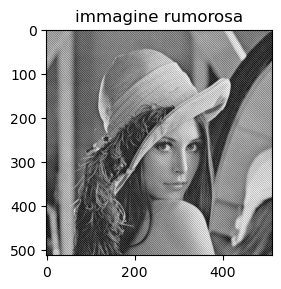

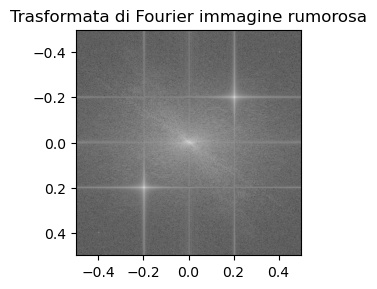

In [353]:
x = np.fromfile('immagini\\lenarumorosa.y',np.int16)
#l'immagine ci viene fornita come "grezza" quindi devo costruire l'immagine tramite reshape che restituisce una matrice 512x512
x = np.reshape(x, [512,512])

x = np.float64(x)
plt.figure(); plt.subplot(1,2,1); plt.imshow(x, clim=[0,255], cmap='gray'); plt.title('immagine rumorosa'); 

X = np.fft.fftshift(np.fft.fft2(x));
plt.figure(); plt.subplot(1,2,2); plt.imshow(np.log(1+np.abs(X)), clim=None, cmap='gray', extent=(-0.5,+0.5,+0.5,-0.5)); plt.title('Trasformata di Fourier immagine rumorosa'); 


L'interpretazione della trasformata: a Lena è stata sommata una sinusoidi con una certa direzione. La trasformata viene così, con la griglia, la sinusoide presa è moltiplicata per una rect perché non la prendo da -inf a +inf quindi avrò in frequenza due delta convolute con una sinc! Sono due perché lo spettro è pari anzitutto, sono centrate a 0.2 quindi vuol dire che la sinusoide aggiunta è alla frequenza 0.2.
**Esercizio** Togliere il rumore e ritornare a Lena pulita. Si fa eliminando una porzione. Si potrebbe creare una griglia dove da applicare che sommata toglie la griglia, ovviamente modifica l'immagine e non uscirà perfettissima.